In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import utils.plot as plot
import xarray as xr
import gcsfs
import dscnn
import climdex.temperature as tdex
from regions import southeast_us, pacific_nw
from datasource import EraiRasDataLoader
from utils.pipeline_v2 import Pipeline, fillnan, clip
from utils.preprocessing import remove_monthly_means, restore_monthly_means
from utils.distributions import normal, bernoulli_gamma
from utils.plot import plot_image_map
from tensorflow.keras.optimizers import Adamax
from tqdm import tqdm
from normalizing_flows.models import VariationalModel, FlowLVM, JointFlowLVM, adversarial
from normalizing_flows.models.variational import nll_loss
from normalizing_flows.models.optimization import LinearWarmupSchedule
from normalizing_flows.flows import Transform, Flow, Invert
from normalizing_flows.flows.image import Upsample
from normalizing_flows.flows.glow import GlowFlow, LogGaussianize, Exponentiate, coupling_nn_glow
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/numba/types/containers.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
erai_deg1_seus = pacific_nw(erai_deg1)
ras_deg1_seus = pacific_nw(ras_deg1)
ras_deg12_seus = pacific_nw(ras_deg12, scale_factor=2)
ras_deg14_seus = pacific_nw(ras_deg14, scale_factor=4)
ras_deg18_seus = pacific_nw(ras_deg18, scale_factor=8)
# create train/test splits
split_fn = data_util.create_time_series_train_test_generator(n_splits=3)
def preprocess_prcp(ds):
    prcp = ds[['PRCP']].fillna(0.).clip(min=0.0, max=np.inf)
    prcp = xr.where(prcp < 1.0, 0.0, prcp)
    return np.cbrt(prcp)
ras_seus_prcp_12 = preprocess_prcp(ras_deg12_seus)
ras_seus_prcp_14 = preprocess_prcp(ras_deg14_seus)
ras_seus_prcp_18 = preprocess_prcp(ras_deg18_seus)
ras_seus_prcp_1 = preprocess_prcp(ras_deg1_seus)
erai_seus_prcp_1 = preprocess_prcp(erai_deg1_seus)
N = ras_deg1.Time.size
# create validation folds from all but last year of data
folds = list(split_fn(ras_seus_prcp_12.isel(Time=slice(0,N-365)), ras_seus_prcp_14.isel(Time=slice(0,N-365))))

<xarray.DataArray 'lat' (lat: 8)>
array([44., 45., 46., 47., 48., 49., 50., 51.], dtype=float32)
Coordinates:
  * lat      (lat) float32 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 <xarray.DataArray 'lon' (lon: 16)>
array([232., 233., 234., 235., 236., 237., 238., 239., 240., 241., 242., 243.,
       244., 245., 246., 247.], dtype=float32)
Coordinates:
  * lon      (lon) float32 232.0 233.0 234.0 235.0 ... 244.0 245.0 246.0 247.0


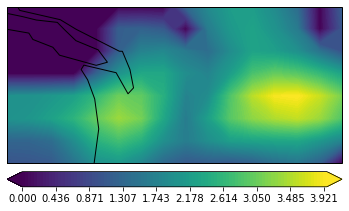

In [4]:
arr = erai_seus_prcp_1['PRCP']
plot_image_map(arr[0], arr.lat, arr.lon)
print(arr.lat, arr.lon)

In [4]:
def preprocess_vds(data_lo, data_hi, batch_size=100, buffer_size=1000, supervised=True):
    if supervised:
        data = tf.data.Dataset.zip((data_lo, data_hi)).shuffle(buffer_size)
    else:
        data = tf.data.Dataset.zip((data_lo.shuffle(buffer_size), data_hi.shuffle(buffer_size)))
    return data.batch(batch_size)

In [5]:
def plot_1xn(data, title, cmin=-10., cmax=10.):
    n = len(data)
    plt.figure(figsize=(n*9,6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(data[i].numpy().squeeze(), origin='lower')
        plt.colorbar(pad=0.04, shrink=0.5)
    plt.suptitle(title, y=0.82)
    plt.show()

In [6]:
indices = tdex.indices('Time')
def eval_climdex(true, pred, coords):
    true_arr = xr.DataArray(true, coords=coords)
    pred_arr = xr.DataArray(pred, coords=coords)
    txx_true = indices.monthly_txx(true_arr)
    txx_pred = indices.monthly_txx(pred_arr)
    txn_true = indices.monthly_txn(true_arr)
    txn_pred = indices.monthly_txn(pred_arr)
    txx_bias = txx_pred - txx_true
    txn_bias = txn_pred - txn_true
    return txx_bias, txn_bias

### Glow: Latent variable estimation

The goal of variational inference is to estimate $q(z) \approx p(z|x) = \frac{p(x,z)}{\int p(x,z)dz}$

Normalizing flows attempt to learn an invertible function $f$ s.t. for $z_0$ drawn form initial variational density $q_0$, $z = f(z_0) \sim q(z)$, where $f$ is arbitrarily complex. This allows the model to learn better approximations of the posterior than otherwise possible with traditional, simple variational densities (such as a spherical Gaussian or standard logistic).

Glow (Kingma et al. 2018) is a state of the art normalizing flow designed for image data. It is an extension of RealNVP that generalizes the channel-wise permutation steps using an invertible 1x1 convolution.

In [ ]:
def upsample(new_wt, new_ht, method, scale_factor=1):
    @tf.function
    def _upsample(x):
        return tf.image.resize(x, (new_wt,new_ht), method=method) / scale_factor
    return _upsample

def spatial_mae(scale):
    """https://duckduckgo.com/?q=gamma+distribution&t=canonical&ia=web
    "Spatial" MAE auxiliary loss for generator. Penalizes outputs
    which violate spatial average preservation between input and output.
    """
    kernel = tf.ones((scale,scale,1,1)) / (scale**2.)
    def _spatial_mse(x_in, y_pred):
        x_avg = tf.nn.conv2d(x_in, kernel, strides=(1, 1), padding='VALID')
        y_avg = tf.nn.conv2d(y_pred, kernel, strides=(1, 1), padding='VALID')
        return tf.math.reduce_mean(tf.math.abs(y_avg - x_avg))
    return _spatial_mse

def fit_glow_jflvm(fold, n_epochs=50, validate_freq=1, warmup=1, sample_batch_size=10, load_batch_size=1200,
                   layers=4, depth=8, min_filters=32, max_filters=256, lam=1.0, alpha=1.0, critic_pre_train_steps=10):
    ((train_lo, train_hi), (test_lo, test_hi)) = fold
    N_train, N_test = train_lo.Time.size, test_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    scale = wt_hi // wt
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
#     train_lo, monthly_means_lo = remove_monthly_means(train_lo)
#     train_hi, monthly_means_hi = remove_monthly_means(train_hi)
#     test_lo,_ = remove_monthly_means(test_lo, monthly_means_lo)
#     test_hi,_ = remove_monthly_means(test_hi, monthly_means_hi)
    train_scale_lo = train_lo.max()
    train_scale_hi = train_hi.max()
    train_lo = (train_lo / train_scale_lo) - 0.5
    train_hi = (train_hi / train_scale_hi) - 0.5
    test_lo = (test_lo / train_scale_lo) - 0.5
    test_hi = (test_hi / train_scale_hi) - 0.5
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR, scale_factor=scale))
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR, scale_factor=scale))
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, batch_size=sample_batch_size, buffer_size=N_train, supervised=False)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=sample_batch_size, buffer_size=N_test, supervised=False)
    test_ds_paired = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=1, buffer_size=N_test, supervised=True)
    flow_hr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256)))
                              #nonnegative=True, parameterize_ctor=LogGaussianize))
    flow_lr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256)))
                              #nonnegative=True, parameterize_ctor=LogGaussianize))
    #learning_rate = LinearWarmupSchedule(1.0E-3, num_warmup_steps=N_train//sample_batch_size*warmup_epochs)
    #p = (train_hi > 0).sum() / train_hi.count()
    prior = tfp.distributions.LogNormal(loc=-0.5, scale=1.0)
    dx = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    dy = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
#     model = FlowLVM(flow_hr, prior=prior, input_shape=(None,wt_hi,ht_hi,1))
#     model.train(train_ds.map(lambda x,y: y), steps_per_epoch=N_train//sample_batch_size, num_epochs=10)
#     samples = model.sample(n=4)
#     plot_1xn(samples, r"Samples $y \sim P(Y)$")
    model_joint = JointFlowLVM(flow_lr, flow_hr, dx, dy, Gy_aux_loss=spatial_mae(scale), input_shape=(None,wt_hi,ht_hi,1),
                               prior=prior)
    for i in range(0, n_epochs, validate_freq):
        print(f'Training joint model for {validate_freq} epochs ({i}/{n_epochs} complete)', flush=True)
        model_joint.train(train_ds, steps_per_epoch=N_train//sample_batch_size, num_epochs=validate_freq,
                          lam=lam, alpha=alpha, critic_pre_train_steps=critic_pre_train_steps)
        metrics = model_joint.evaluate(test_ds, N_test//sample_batch_size)
        # extract and log metrics
        mlflow.log_metrics({k: v[0] for k, v in metrics.items()})
        samples_x, samples_y = model_joint.sample(n=4)
        plot_1xn(samples_x, r"Samples $x \sim P(X)$")
        plot_1xn(samples_y, r"Samples $y \sim P(Y)$")
        x_t, y_t = next(test_ds_paired.__iter__())
        xp_t = model_joint.predict_x(y_t)
        yp_t = model_joint.predict_y(x_t)
        plot_1xn([x_t[0], y_t[0], xp_t[0], yp_t[0]], r"Predictions $X \leftrightarrow Y$")
        y_true, y_pred = [], []
        for x, y in tf.data.Dataset.zip((test_lo_ds, test_hi_ds)).batch(2*sample_batch_size):
            y_true.append(y)
            z, ildj = model_joint.G_zx.inverse(x)
            y_, fldj = model_joint.G_zy.forward(z)
            y_pred.append(y_)
        y_true = tf.concat(y_true, axis=0)
        y_pred = tf.concat(y_pred, axis=0)
        txx_bias, txn_bias = eval_climdex(y_true.numpy(), y_pred.numpy(), test_hi.coords)
        txx_bias_mean, txx_bias_std = txx_bias.mean().values, txx_bias.std().values
        txn_bias_mean, txn_bias_std = txn_bias.mean().values, txn_bias.std().values
        print(f'txx bias avg: {txx_bias_mean}, std: {txx_bias_std}')
        print(f'txn bias avg: {txn_bias_mean}, std: {txn_bias_std}')
        mlflow.log_metrics({'txx_bias_avg': float(txx_bias_mean), 'txx_bias_std': float(txx_bias_std)})
        mlflow.log_metrics({'txn_bias_avg': float(txn_bias_mean), 'txn_bias_std': float(txn_bias_std)})
        rmse = tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2, axis=[1,2,3]))
        mlflow.log_metric('rmse', tf.math.reduce_mean(rmse).numpy())
        plt.figure(figsize=(2*8,6))
        plt.subplot(1,2,1)
        plt.plot(range(txx_bias.Time.size), txx_bias.mean(dim=['lat','lon']), c='r')
        plt.plot(range(txn_bias.Time.size), txn_bias.mean(dim=['lat','lon']), c='b')
        plt.title('Monthly TX max/min validation bias')
        plt.xlabel('Months from $t_0$')
        plt.ylabel('Bias (K)')
        plt.legend(['txx','txn'])
        plt.subplot(1,2,2)
        plt.plot(range(rmse.shape[0]), rmse, c='g')
        plt.title('Validation RMSE vs time')
        plt.show()
    return model_joint

In [ ]:
mlflow.set_experiment('scratch')
with mlflow.start_run() as run:
    model = fit_glow_jflvm(folds[-1], layers=4, depth=16, lam=0.1, alpha=0.01, n_epochs=20, validate_freq=2, critic_pre_train_steps=0)

In [14]:
def fit_glow_inference_net(fold, n_epochs=50, validate_freq=1, warmup=1, sample_batch_size=10, load_batch_size=1200,
                           layers=4, depth=8, min_filters=32, max_filters=256, lam=1.0, alpha=1.0, critic_pre_train_steps=10):
    ((train_lo, train_hi), (test_lo, test_hi)) = fold
    N_train, N_test = train_lo.Time.size, test_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    scale = wt_hi // wt
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
#     train_lo, monthly_means_lo = remove_monthly_means(train_lo)
#     train_hi, monthly_means_hi = remove_monthly_means(train_hi)
#     test_lo,_ = remove_monthly_means(test_lo, monthly_means_lo)
#     test_hi,_ = remove_monthly_means(test_hi, monthly_means_hi)
#     train_scale_lo = train_lo.max()
#     train_scale_hi = train_hi.max()
#     train_lo = (train_lo / train_scale_lo) - 0.5
#     train_hi = (train_hi / train_scale_hi) - 0.5
#     test_lo = (test_lo / train_scale_lo) - 0.5
#     test_hi = (test_hi / train_scale_hi) - 0.5
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, batch_size=sample_batch_size, buffer_size=N_train, supervised=True)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=sample_batch_size, buffer_size=N_test, supervised=True)
    test_ds_paired = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=1, buffer_size=N_test, supervised=True)
    flow_hr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256),
                              parameterize_ctor=Exponentiate))
    encoder = dscnn.create_bmg_cnn10(wt, ht, scale=scale, c_out=2)
    model = VariationalModel(encoder, bernoulli_gamma())
    model.compile(optimizer=Adamax(lr=1.0E-3), output_shape=(None, wt_hi, ht_hi, 1))
    model.fit(train_ds.repeat(n_epochs), epochs=n_epochs, steps_per_epoch=train_steps,
              validation_data=test_ds.repeat(n_epochs), validation_steps=test_steps)
    test_x, test_y = next(test_ds.__iter__())
    sample = model.sample(test_x, flatten_z=False)
    plt.figure(figsize=(4*9,6))
    plt.subplot(1,4,1)
    plt.imshow(test_x.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,2)
    plt.imshow(test_y.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,3)
    plt.imshow(sample[0].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,4)
    plt.imshow(sample[1].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.show()
    return model

train, epoch 1/5:   0%|          | 0/330 [00:00<?, ?it/s]

3300 training samples, 1083 test samples, 32x64 -> 64x128


test, epoch 5/5:  33%|███▎      | 109/330 [00:04<00:08, 25.91it/s, nll=1.57]


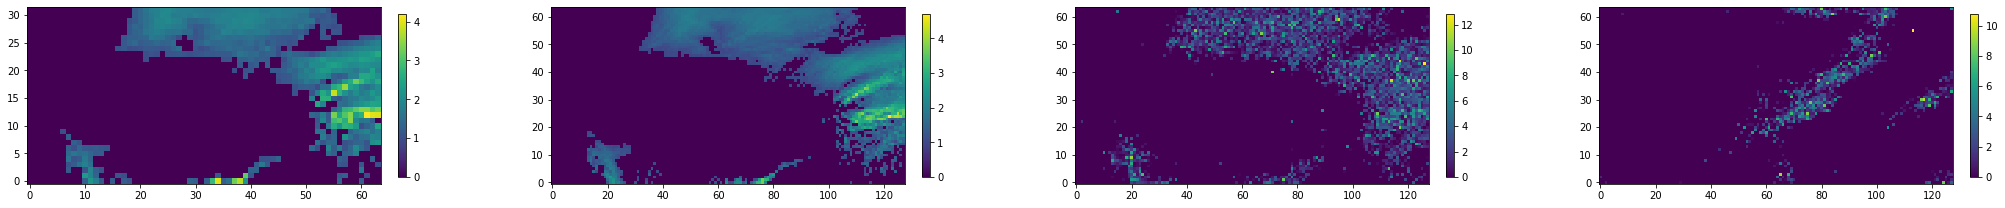

In [15]:
mlflow.set_experiment('scratch')
with mlflow.start_run() as run:
    model = fit_glow_inference_net(folds[-1], layers=4, depth=8, n_epochs=5, validate_freq=2, critic_pre_train_steps=0)